In [44]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter4/insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Exploration

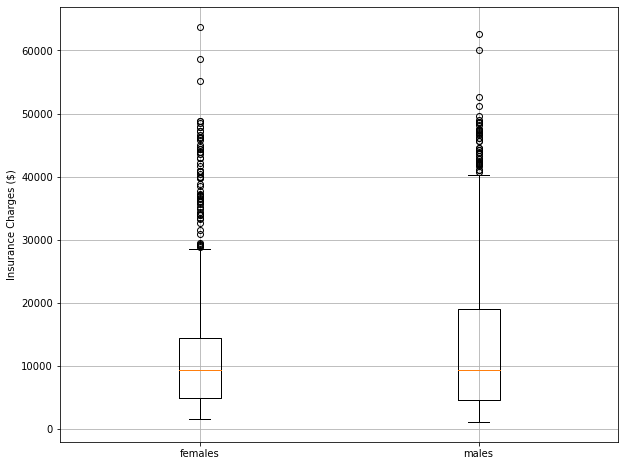

In [45]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
females = insurance[insurance['sex'] == 'female']
males = insurance[insurance['sex'] == 'male']

## Creating side-by-side box plots
plt.boxplot([females['charges'], males['charges']], labels = ['females', 'males'])
plt.ylabel('Insurance Charges ($)')
plt.grid()

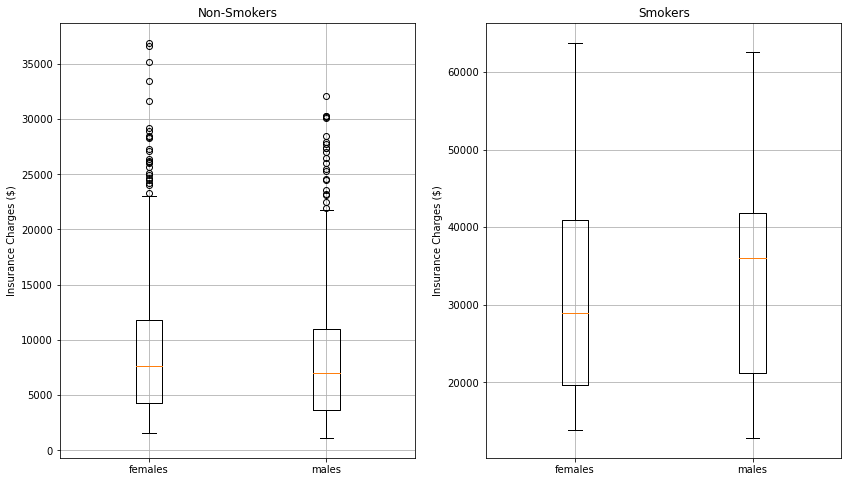

In [46]:
## Creating a new figure
fig, axes = plt.subplots(1, 2, figsize = (14, 8))

## Subsetting the data
nonsmokers_females = insurance[(insurance['sex'] == 'female') & (insurance['smoker'] == 'no')]
nonsmokers_males = insurance[(insurance['sex'] == 'male') & (insurance['smoker'] == 'no')]

smokers_females = insurance[(insurance['sex'] == 'female') & (insurance['smoker'] == 'yes')]
smokers_males = insurance[(insurance['sex'] == 'male') & (insurance['smoker'] == 'yes')]

axes[0].boxplot([nonsmokers_females['charges'], nonsmokers_males['charges']], labels = ['females', 'males'])
axes[0].set_ylabel('Insurance Charges ($)')
axes[0].set_title('Non-Smokers')
axes[0].grid()

## Plotting the second histogram
axes[1].boxplot([smokers_females['charges'], smokers_males['charges']], labels = ['females', 'males'])
axes[1].set_ylabel('Insurance Charges ($)')
axes[1].set_title('Smokers')
axes[1].grid()

In [47]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


[Text(697.5, 713.475, 'smoker <= 0.5\nmse = 147679155.657\nsamples = 1070\nvalue = 13316.122'),
 Text(348.75, 509.625, 'age <= 42.5\nmse = 36079213.309\nsamples = 856\nvalue = 8522.766'),
 Text(174.375, 305.775, 'children <= 0.5\nmse = 23162482.79\nsamples = 477\nvalue = 5547.472'),
 Text(87.1875, 101.92499999999995, 'mse = 15684927.378\nsamples = 197\nvalue = 3869.364'),
 Text(261.5625, 101.92499999999995, 'mse = 25048209.528\nsamples = 280\nvalue = 6728.141'),
 Text(523.125, 305.775, 'age <= 51.5\nmse = 27172247.428\nsamples = 379\nvalue = 12267.397'),
 Text(435.9375, 101.92499999999995, 'mse = 21939279.57\nsamples = 165\nvalue = 10202.677'),
 Text(610.3125, 101.92499999999995, 'mse = 25385741.056\nsamples = 214\nvalue = 13859.354'),
 Text(1046.25, 509.625, 'bmi <= 29.972\nmse = 134553727.583\nsamples = 214\nvalue = 32489.545'),
 Text(871.875, 305.775, 'age <= 41.0\nmse = 25298401.475\nsamples = 98\nvalue = 21429.236'),
 Text(784.6875, 101.92499999999995, 'mse = 13426284.0\nsamples =

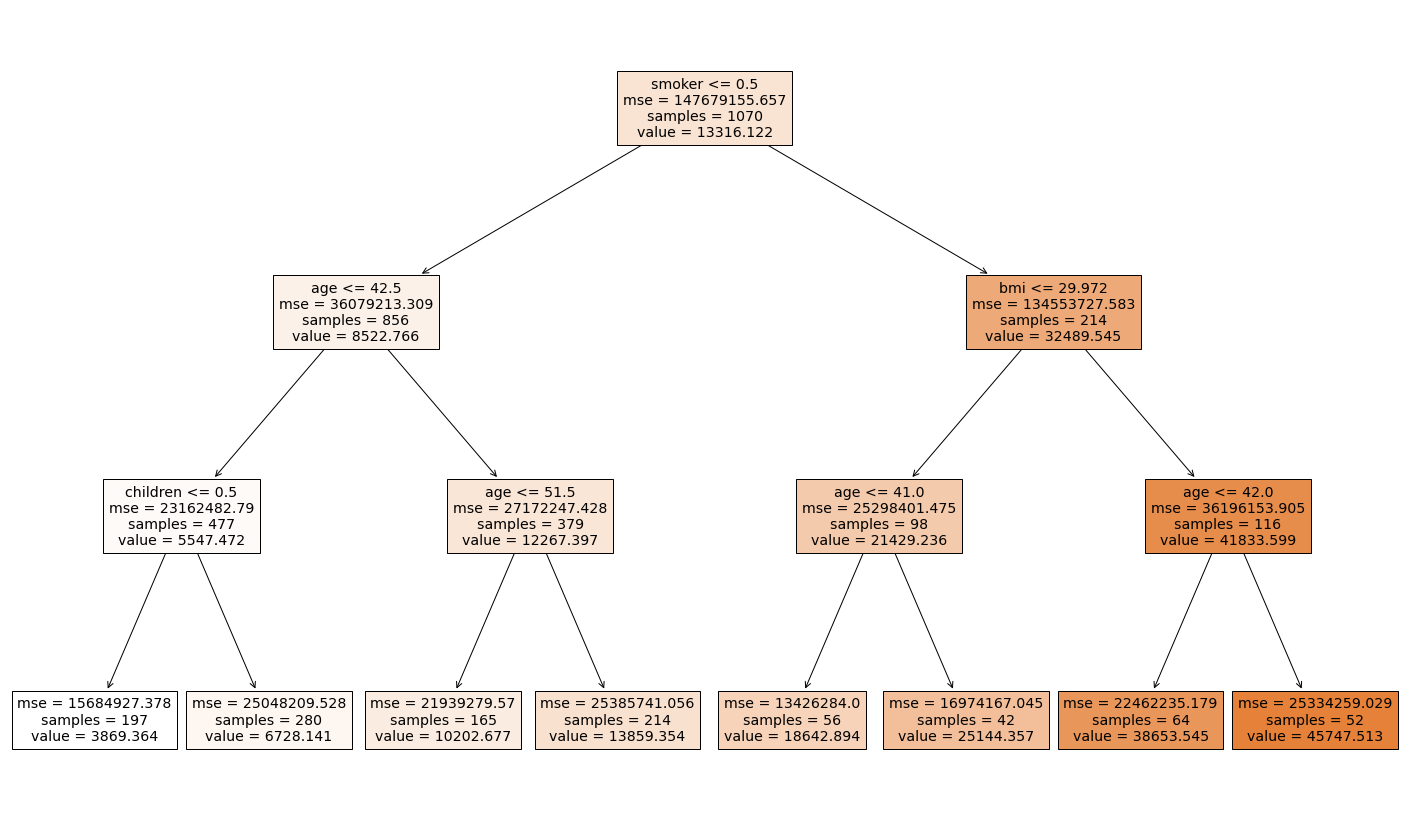

In [60]:
## Defining the input and target variables
X = insurance.drop(columns = ['charges', 'region'], axis = 1)
Y = insurance['charges']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)



In [49]:
## Forcing to be data-frames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Engineering features
X_train['interaction_1'] = np.where((X_train['smoker'] == 0) & (X_train['age'] <= 32.5), 1, 0)
X_train['interaction_2'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 32.5) & (X_train['age'] <= 44.5), 1, 0)
X_train['interaction_3'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 44.5) & (X_train['age'] < 51.5), 1, 0)
X_train['interaction_1'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 51.5), 1, 0)

X_test['interaction_1'] = np.where((X_test['smoker'] == 0) & (X_test['age'] <= 32.5), 1, 0)
X_test['interaction_2'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 32.5) & (X_test['age'] <= 44.5), 1, 0)
X_test['interaction_3'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 44.5) & (X_test['age'] < 51.5), 1, 0)
X_test['interaction_1'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 51.5), 1, 0)

In [56]:
## Running RFE with Random forest model
RF_rfe = RFE(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), n_features_to_select = 5).fit(X_train, Y_train)
RF_rfe

RFE(estimator=RandomForestRegressor(max_depth=3, n_estimators=500),
    n_features_to_select=5)

In [57]:
RF_rfe.ranking_

array([1, 7, 1, 1, 1, 4, 6, 5, 1, 3, 2])

In [58]:
RF_rfe.support_

array([ True, False,  True,  True,  True, False, False, False,  True,
       False, False])

In [59]:
X_train.columns[RF_rfe.support_]

Index(['age', 'bmi', 'children', 'smoker', 'interaction_1'], dtype='object')